In [1]:
import sys

sys.path.append("..")

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
import ast
import json
import numpy as np
import pandas as pd
import torch
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from torch.utils.data import TensorDataset, DataLoader
from typing import List
from collections import defaultdict
from tqdm import tqdm
from datasets import load_dataset

from src.tcav.model import MusicGenreClassifier
from src.tcav.tcav import TCAV
from src.constants import (
    GTZAN_PATH, 
    TCAV_RESULTS_PATH, 
    GENRE_CLASSIFIER_MODEL_CHECKPOINT_PATH, 
    GTZAN_GENRES, 
    GENRE_TO_IDX, 
    NUM_GENRES,
    DEFAULT_NUM_RANDOM_SAMPLES, 
    DEFAULT_NUM_CONCEPT_SAMPLES, 
    DEFAULT_NUM_CAV_RUNS
)

pl.seed_everything(42)

sns.set_style('whitegrid')
plt.rcParams.update({
    'figure.figsize': (18, 8),
    'font.size': 32,
    'axes.titlesize': 28,
    'axes.labelsize': 25,
    'xtick.labelsize': 23,
    'ytick.labelsize': 23,
    'legend.fontsize': 21
})

TRAIN_MODEL = False
RUN_TCAV_ANALYSIS = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

/home/bruno/miniconda3/envs/conceptcaps/lib/python3.12/site-packages/torchmetrics/utilities/imports.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
Seed set to 42


Device: cuda


## Define helping variables and methods

In [4]:
# Load concept-to-tags mapping
CONCEPTS = json.load(open("../data/concepts_to_tags.json", "r"))

print("Available concept categories:")
for cat, tags in CONCEPTS.items():
    print(f"  {cat}: {len(tags)} tags (e.g., {tags[:3]})")

Available concept categories:
  tempo: 50 tags (e.g., ['medium tempo', 'slow tempo', 'fast tempo'])
  genre: 50 tags (e.g., ['rock', 'pop', 'electronic music'])
  mood: 50 tags (e.g., ['emotional', 'passionate', 'energetic'])
  instrument: 50 tags (e.g., ['acoustic drums', 'electric guitar', 'bass guitar'])


In [5]:
# Create reverse mapping
TAG_TO_CATEGORY = {}
for cat, tags in CONCEPTS.items():
    for tag in tags:
        TAG_TO_CATEGORY[tag] = cat

In [6]:
def preprocess_audio(audio_array: np.ndarray, sr: int, target_sr: int = 16000, duration: float = 3.0) -> torch.Tensor:
    """Preprocess audio to fixed length and sample rate."""
    if sr != target_sr:
        audio_array = librosa.resample(audio_array, orig_sr=sr, target_sr=target_sr)
    
    target_length = int(target_sr * duration)
    if len(audio_array) > target_length:
        audio_array = audio_array[:target_length]
    else:
        audio_array = np.pad(audio_array, (0, target_length - len(audio_array)))
    
    return torch.from_numpy(audio_array).float()

## Load GTZAN Dataset and Train Classifier

In [ ]:
print("Loading GTZAN dataset from local files...")

print("Scanning audio files...")
audio_files = []
for genre in GTZAN_GENRES:
    genre_path = GTZAN_PATH / genre
    wav_files = sorted(genre_path.glob("*.wav"))
    for wav_file in wav_files:
        audio_files.append({
            'path': wav_file,
            'genre': genre,
            'label': GENRE_TO_IDX[genre]
        })

print(f"Loaded {len(audio_files)} audio files")
print(f"Genres: {GTZAN_GENRES}")
print(f"Files per genre: ~{len(audio_files) // len(GTZAN_GENRES)}")

Loading GTZAN dataset from local files...
Scanning audio files...
Loaded 1000 audio files
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Files per genre: ~100


In [8]:
print("Loading and preprocessing GTZAN audio files...")
X_train, y_train = [], []

for file_info in tqdm(audio_files, desc="Loading audio"):
    try:
        audio, sr = librosa.load(file_info['path'], sr=None, mono=True)
    except Exception as e:
        print(f"Error loading {file_info['path']}: {e}")
        continue
    
    audio_tensor = preprocess_audio(audio, sr)
    X_train.append(audio_tensor)
    y_train.append(file_info['label'])

X_train = torch.stack(X_train)
y_train = torch.tensor(y_train)

print(f"Training data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")

Loading and preprocessing GTZAN audio files...


Loading audio:  55%|█████▌    | 553/1000 [00:05<00:03, 116.30it/s]/tmp/ipykernel_296970/751458001.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_info['path'], sr=None, mono=True)
/home/bruno/miniconda3/envs/conceptcaps/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Loading audio:  58%|█████▊    | 577/1000 [00:05<00:04, 105.72it/s]

Error loading /media/bruno/B438-3BD6/datasets/GTZAN/Data/genres_original/jazz/jazz.00054.wav: 


Loading audio: 100%|██████████| 1000/1000 [00:09<00:00, 104.58it/s]

Training data shape: torch.Size([999, 48000])
Labels shape: torch.Size([999])


In [ ]:
model = MusicGenreClassifier(num_genres=NUM_GENRES)
print(f"Model params: {sum(p.numel() for p in model.parameters()):,}")

Model params: 128,714


In [10]:
GENRE_CLASSIFIER_MODEL_CHECKPOINT_PATH.parent.mkdir(parents=True, exist_ok=True)

print(f"Training mode: {'ENABLED' if TRAIN_MODEL else 'DISABLED'}")
print(f"Model checkpoint path: {GENRE_CLASSIFIER_MODEL_CHECKPOINT_PATH}")

Training mode: DISABLED
Model checkpoint path: ../models/best-genre-classifier.ckpt


In [ ]:
if TRAIN_MODEL:
    print("Training genre classifier on GTZAN...")
    
    indices = torch.randperm(len(X_train))
    train_size = int(0.8 * len(X_train))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    X_train_split = X_train[train_indices]
    y_train_split = y_train[train_indices]
    X_val = X_train[val_indices]
    y_val = y_train[val_indices]
    
    train_dataset = TensorDataset(X_train_split, y_train_split)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=16, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=16, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath=GENRE_CLASSIFIER_MODEL_CHECKPOINT_PATH.parent,
        filename='genre_classifier_best',
        monitor='val_acc',
        mode='max',
        save_top_k=1,
        save_last=True
    )
    
    trainer = pl.Trainer(
        max_epochs=100,
        accelerator='auto',
        devices=1,
        callbacks=[
            checkpoint_callback,
            pl.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                mode='min'
            )
        ],
    )
    
    trainer.fit(model, train_loader, val_loader)
    
    print(f"Model training complete!")
    print(f"Best model saved to: {checkpoint_callback.best_model_path}")
    
    model = MusicGenreClassifier.load_from_checkpoint(
        checkpoint_callback.best_model_path,
        num_genres=len(GTZAN_GENRES)
    )
    
else:
    print("Loading pre-trained model from checkpoint...")
    
    if GENRE_CLASSIFIER_MODEL_CHECKPOINT_PATH.exists():
        model = MusicGenreClassifier.load_from_checkpoint(
            GENRE_CLASSIFIER_MODEL_CHECKPOINT_PATH,
            num_genres=len(GTZAN_GENRES)
        )
        print(f"Model loaded from: {GENRE_CLASSIFIER_MODEL_CHECKPOINT_PATH}")
    else:
        print(f"Checkpoint not found at {GENRE_CLASSIFIER_MODEL_CHECKPOINT_PATH}")
        print("Please set TRAIN_MODEL=True to train a new model first.")
        raise FileNotFoundError(f"Model checkpoint not found: {GENRE_CLASSIFIER_MODEL_CHECKPOINT_PATH}")
model = model.to(device)
model.eval()

print(f"Model ready on {device}")

Loading pre-trained model from checkpoint...
Model loaded from: ../models/best-genre-classifier.ckpt
Model ready on cuda


In [12]:
print("Evaluating model accuracy on GTZAN validation set...")
val_dataset = TensorDataset(X_train, y_train)
val_loader = DataLoader(
    val_dataset, 
    batch_size=16, 
    shuffle=False, 
    num_workers=4,
    pin_memory=True
)
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs, return_bottleneck=False)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f"Validation Accuracy on GTZAN: {accuracy * 100:.2f}%")

Evaluating model accuracy on GTZAN validation set...


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 84.01it/s] 

Validation Accuracy on GTZAN: 86.19%


## Load ConceptCaps Dataset

In [ ]:
conceptcaps = load_dataset("bsienkiewicz/ConceptCaps", "25pct-audio", split="all")

In [22]:
def get_audio_by_tags(tag: str, num_samples: int) -> List[torch.Tensor]:
    samples = []
    
    for idx, sample in enumerate(conceptcaps):
        all_aspects = (
            sample['genre_aspects'] + 
            sample['mood_aspects'] + 
            sample['instrument_aspects'] + 
            sample['tempo_aspects']
        )
        
        if tag in all_aspects:
            try:
                audio_data = sample['file_name']
                audio_array = audio_data['array']
                sr = audio_data['sampling_rate']

                audio_tensor = preprocess_audio(audio_array, sr)
                samples.append(audio_tensor)
                
                if len(samples) >= num_samples:
                    break
            except Exception as e:
                print(f"Error loading audio for sample {idx}: {e}")
                continue
    
    if num_samples > len(samples):
        print(f"Warning: Found {len(samples)}/{num_samples} samples.")

    return samples[:num_samples]


def create_concept_dataset_from_audio(concept: str, num_samples: int = 20) -> torch.Tensor:
    samples = get_audio_by_tags(concept, num_samples)
    return torch.stack(samples)


def create_random_audio_dataset(num_samples: int = 30) -> torch.Tensor:
    samples = []
    indices = np.random.choice(len(conceptcaps), num_samples, replace=False)
    
    for idx in indices:
        try:
            sample = conceptcaps[int(idx)]
            audio_data = sample['file_name']
            audio_array = audio_data['array']
            sr = audio_data['sampling_rate']

            audio_tensor = preprocess_audio(audio_array, sr)
            samples.append(audio_tensor)
        except Exception as e:
            print(f"Error loading audio for sample {idx}: {e}")
            continue
    
    return torch.stack(samples)

## Run TCAV Analysis

In [19]:
tcav = TCAV(model, device)
print("TCAV analyzer initialized with improved implementation.")

TCAV analyzer initialized with improved implementation.


In [54]:
aspects_by_category = {
    'instrument': set(),
    'tempo': set()
}

for sample in conceptcaps:
    aspects_by_category['instrument'].update(sample['instrument_aspects'])
    aspects_by_category['tempo'].update(sample['tempo_aspects'])

ANALYSIS_CONCEPTS = {
    'tempo': [],
    'instrument': [],
}

### Select only the most popular concepts

In [58]:
for category in ANALYSIS_CONCEPTS:
    concept_counts = defaultdict(int)
    for sample in conceptcaps:
        if category == 'tempo':
            for aspect in sample['tempo_aspects']:
                concept_counts[aspect] += 1
        elif category == 'instrument':
            for aspect in sample['instrument_aspects']:
                concept_counts[aspect] += 1
    sorted_concepts = sorted(concept_counts.items(), key=lambda x: x[1], reverse=True)
    top_concepts = [concept for concept, count in sorted_concepts[:15]]
    ANALYSIS_CONCEPTS[category] = top_concepts
print("Concepts selected for TCAV analysis:")
for cat, concepts in ANALYSIS_CONCEPTS.items():
    print(f"  {cat}: {concepts}")

Concepts selected for TCAV analysis:
  tempo: ['medium tempo', 'slow tempo', 'groovy', 'fast tempo', 'upbeat', 'uptempo', 'medium fast tempo', 'moderate tempo', 'medium to uptempo', 'dance rhythm', 'dance groove', 'groovy rhythm', 'slower tempo', 'rhythmic acoustic guitar', 'steady rhythm']
  instrument: ['acoustic guitar', 'acoustic drums', 'bass', 'piano', 'electric guitar', 'drums', 'percussion', 'male vocal', 'groovy bass', 'male singer', 'bass guitar', 'electronic drums', 'keyboard', 'punchy kick', 'keyboard harmony']


In [ ]:
if RUN_TCAV_ANALYSIS:
    random_data = create_random_audio_dataset(num_samples=DEFAULT_NUM_RANDOM_SAMPLES)
    random_acts = tcav.get_activations(random_data)

    results = defaultdict(dict)
    for category, concept_list in ANALYSIS_CONCEPTS.items():
        print(f"Category: {category.upper()}")
        print("-" * 40)
        
        for concept in concept_list:
            print(f"  Loading audio for '{concept}'...")
            concept_data = create_concept_dataset_from_audio(concept, num_samples=DEFAULT_NUM_CONCEPT_SAMPLES)

            if concept_data.shape[0] < DEFAULT_NUM_CONCEPT_SAMPLES:
                print(f"  Skipping concept '{concept}' due to insufficient samples.")
                continue

            concept_acts = tcav.get_activations(concept_data)
            
            cav_result = tcav.train_cav(concept_acts, random_acts, num_runs=DEFAULT_NUM_CAV_RUNS)

            if cav_result['accuracy'] < 0.65:
                print(f"  Skipping concept '{concept}' due to low CAV accuracy ({cav_result['accuracy']:.3f}).")
                continue
            
            genre_scores = {}
            for genre_name in GTZAN_GENRES:
                genre_idx = GENRE_TO_IDX[genre_name]
                genre_mask = y_train == genre_idx
                genre_samples = X_train[genre_mask]
                
                genre_acts = tcav.get_activations(genre_samples)
                genre_scores[genre_name] = tcav.compute_tcav_score(genre_acts, cav_result['cav'])
            
            results[category][concept] = {
                'cav_accuracy': cav_result['accuracy'],
                'genre_scores': genre_scores
            }
            
            print(f"  {concept}: CAV acc={cav_result['accuracy']:.3f}")

    with open(TCAV_RESULTS_PATH, "w") as f:
        json.dump(results, f, indent=4)
    print(f"TCAV results saved to: {TCAV_RESULTS_PATH}")
else:
    with open(TCAV_RESULTS_PATH, "r") as f:
        results = json.load(f)
    print(f"TCAV results loaded from: {TCAV_RESULTS_PATH}")

Category: TEMPO
----------------------------------------
  Loading audio for 'medium tempo'...
  Skipping concept 'medium tempo' due to low CAV accuracy (0.644).
  Loading audio for 'slow tempo'...
  slow tempo: CAV acc=0.657
  Loading audio for 'groovy'...
  groovy: CAV acc=0.650
  Loading audio for 'fast tempo'...
  fast tempo: CAV acc=0.668
  Loading audio for 'upbeat'...
  upbeat: CAV acc=0.660
  Loading audio for 'uptempo'...
  uptempo: CAV acc=0.670
  Loading audio for 'medium fast tempo'...
  Skipping concept 'medium fast tempo' due to low CAV accuracy (0.633).
  Loading audio for 'moderate tempo'...
  moderate tempo: CAV acc=0.678
  Loading audio for 'medium to uptempo'...


[rank: 0] No CAVs with accuracy > 0.6 found


  Skipping concept 'medium to uptempo' due to low CAV accuracy (0.000).
  Loading audio for 'dance rhythm'...
  Skipping concept 'dance rhythm' due to insufficient samples.
  Loading audio for 'dance groove'...
  Skipping concept 'dance groove' due to insufficient samples.
  Loading audio for 'groovy rhythm'...
  Skipping concept 'groovy rhythm' due to insufficient samples.
  Loading audio for 'slower tempo'...
  Skipping concept 'slower tempo' due to insufficient samples.
  Loading audio for 'rhythmic acoustic guitar'...
  Skipping concept 'rhythmic acoustic guitar' due to insufficient samples.
  Loading audio for 'steady rhythm'...
  Skipping concept 'steady rhythm' due to insufficient samples.
Category: INSTRUMENT
----------------------------------------
  Loading audio for 'acoustic guitar'...
  acoustic guitar: CAV acc=0.688
  Loading audio for 'acoustic drums'...
  acoustic drums: CAV acc=0.669
  Loading audio for 'bass'...


[rank: 0] No CAVs with accuracy > 0.6 found


  Skipping concept 'bass' due to low CAV accuracy (0.000).
  Loading audio for 'piano'...
  piano: CAV acc=0.675
  Loading audio for 'electric guitar'...
  electric guitar: CAV acc=0.657
  Loading audio for 'drums'...
  drums: CAV acc=0.655
  Loading audio for 'percussion'...
  percussion: CAV acc=0.687
  Loading audio for 'male vocal'...
  male vocal: CAV acc=0.657
  Loading audio for 'groovy bass'...
  groovy bass: CAV acc=0.661
  Loading audio for 'male singer'...
  male singer: CAV acc=0.673
  Loading audio for 'bass guitar'...
  bass guitar: CAV acc=0.667
  Loading audio for 'electronic drums'...
  electronic drums: CAV acc=0.699
  Loading audio for 'keyboard'...
  keyboard: CAV acc=0.650
  Loading audio for 'punchy kick'...
  punchy kick: CAV acc=0.673
  Loading audio for 'keyboard harmony'...
  keyboard harmony: CAV acc=0.664
TCAV results saved to: ../data/tcav_genre_classification_results.json


### Visualize Results

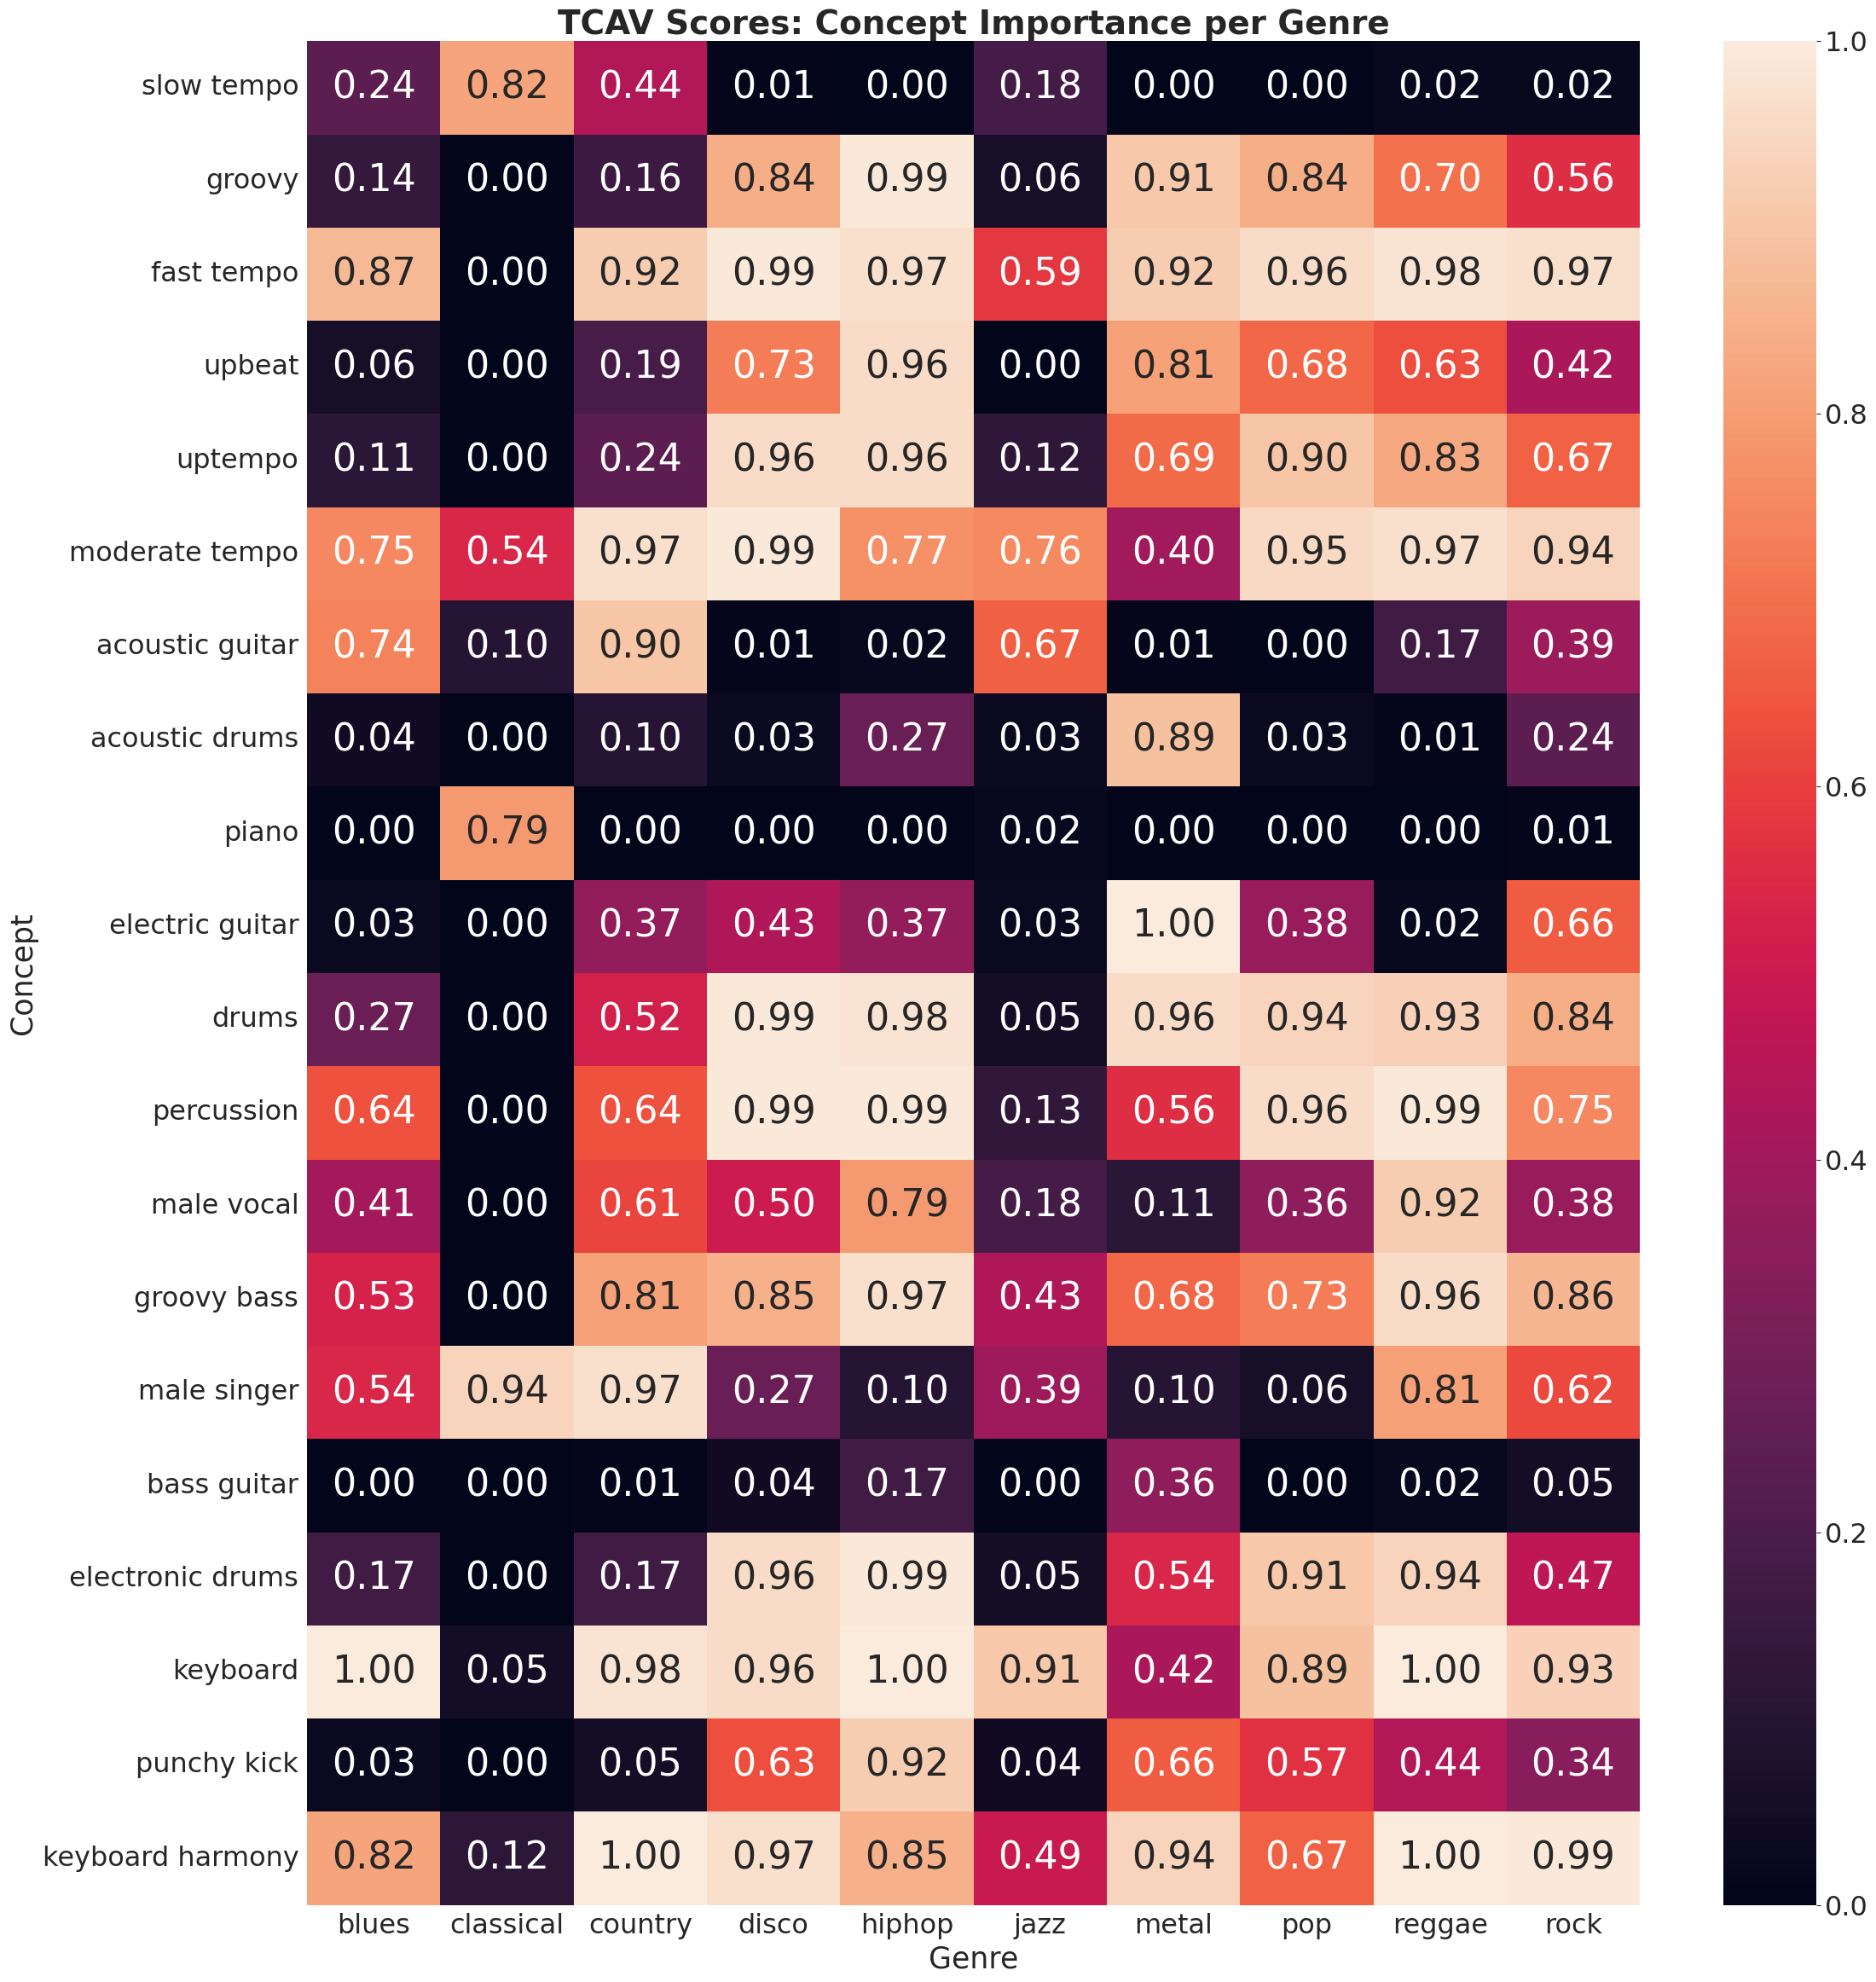

In [ ]:
all_concepts = [c for concepts in ANALYSIS_CONCEPTS.values() for c in concepts]

score_matrix = []
concept_names = []

for category, concept_dict in results.items():
    for concept, data in concept_dict.items():
        scores = [data['genre_scores'].get(g, 0.0) for g in GTZAN_GENRES]
        score_matrix.append(scores)
        concept_names.append(f"{concept}")

score_matrix = np.array(score_matrix)

fig, ax = plt.subplots(figsize=(24, 24))
sns.heatmap(
    score_matrix, 
    xticklabels=GTZAN_GENRES,
    yticklabels=concept_names,
    annot=True, 
    fmt='.2f',
    vmin=0, vmax=1,
    ax=ax,
)
ax.set_title('TCAV Scores: Concept Importance per Genre', fontweight='bold')
ax.set_xlabel('Genre')
ax.set_ylabel('Concept')
plt.tight_layout()
plt.show()

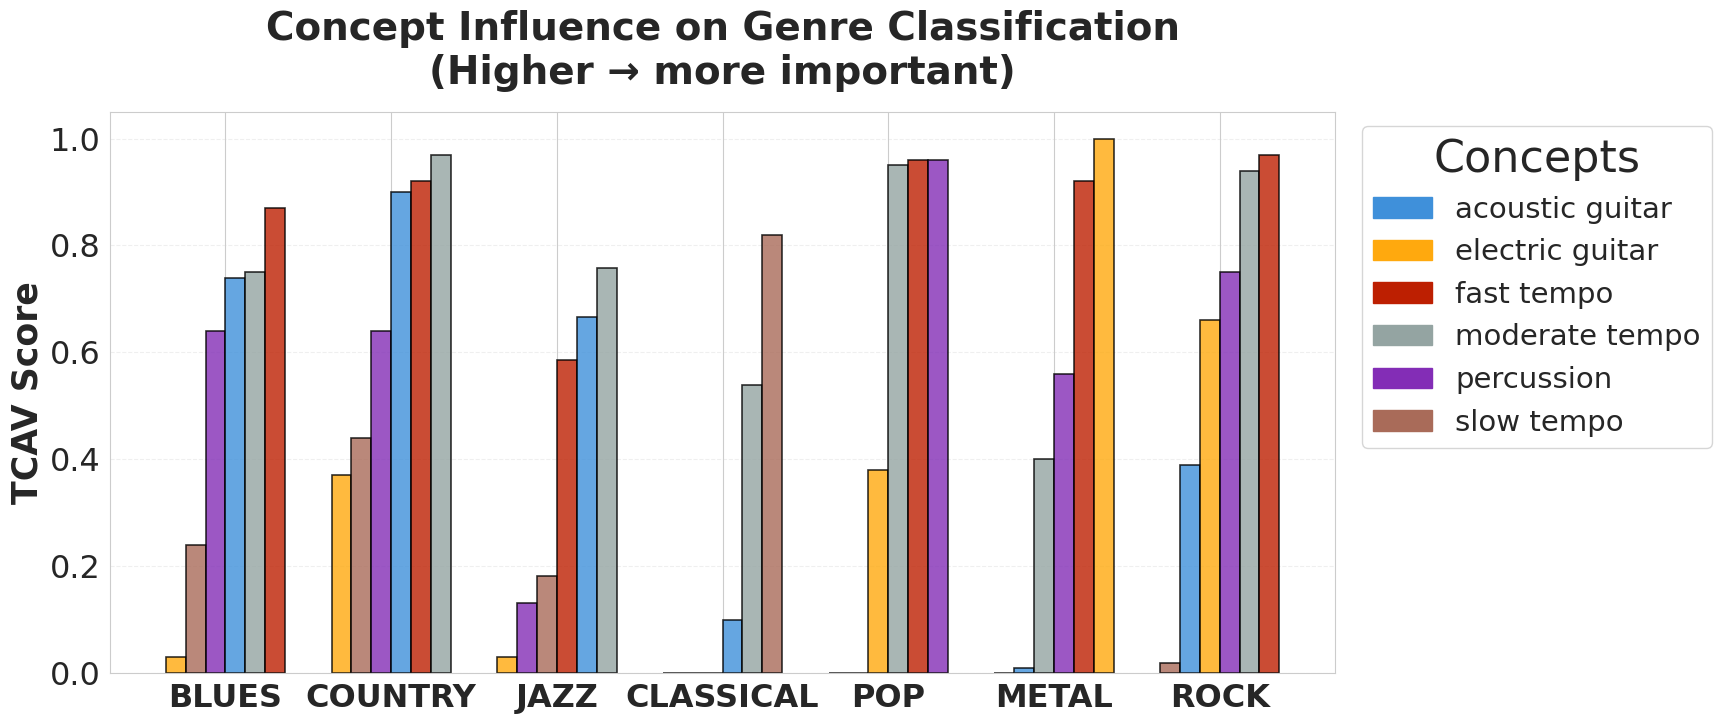

In [62]:
import matplotlib.patches as mpatches

PLOT_GENRES = ['blues', 'country', 'jazz','classical', 'pop', 'metal', 'rock']

PLOT_CONCEPTS = {
    'tempo': ['slow tempo', 'moderate tempo', 'fast tempo'],
    'instrument': ['electric guitar', 'acoustic guitar', 'percussion']
}

all_plot_concepts = [c for cat_list in PLOT_CONCEPTS.values() for c in cat_list]
unique_concepts = sorted(list(set(all_plot_concepts)))
petroff_colors = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
color_map = {concept: color for concept, color in zip(unique_concepts, petroff_colors)}

fig, ax = plt.subplots()
bar_width = 0.12
x_indices = np.arange(len(PLOT_GENRES))

for i, genre in enumerate(PLOT_GENRES):
    genre_data = []
    
    for category, concept_dict in results.items():
        if category not in PLOT_CONCEPTS: continue
        for concept, data in concept_dict.items():
            if concept not in PLOT_CONCEPTS[category]: continue
            
            score = data['genre_scores'].get(genre, 0.0)
            genre_data.append((concept, score))
    
    genre_data.sort(key=lambda x: x[1])
    n_bars = len(genre_data)
    total_group_width = n_bars * bar_width
    start_x = i - (total_group_width / 2) + (bar_width / 2)
    
    for j, (concept, score) in enumerate(genre_data):
        pos = start_x + (j * bar_width)
        ax.bar(pos, score, width=bar_width, edgecolor='black', linewidth=1.2, color=color_map[concept], alpha=0.8)

ax.set_xticks(x_indices)
ax.set_xticklabels([g.upper() for g in PLOT_GENRES], fontweight='bold')
ax.set_ylabel('TCAV Score', fontweight='bold')
ax.set_title('Concept Influence on Genre Classification\n(Higher → more important)', fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')

legend_patches = [mpatches.Patch(color=color_map[c], label=c) for c in unique_concepts]
ax.legend(handles=legend_patches, 
          title='Concepts', 
          bbox_to_anchor=(1.01, 1), 
          loc='upper left',
          frameon=True)

plt.tight_layout()
plt.savefig("../docs/assets/concept_influence_across_genres.pdf", bbox_inches='tight')
plt.show()

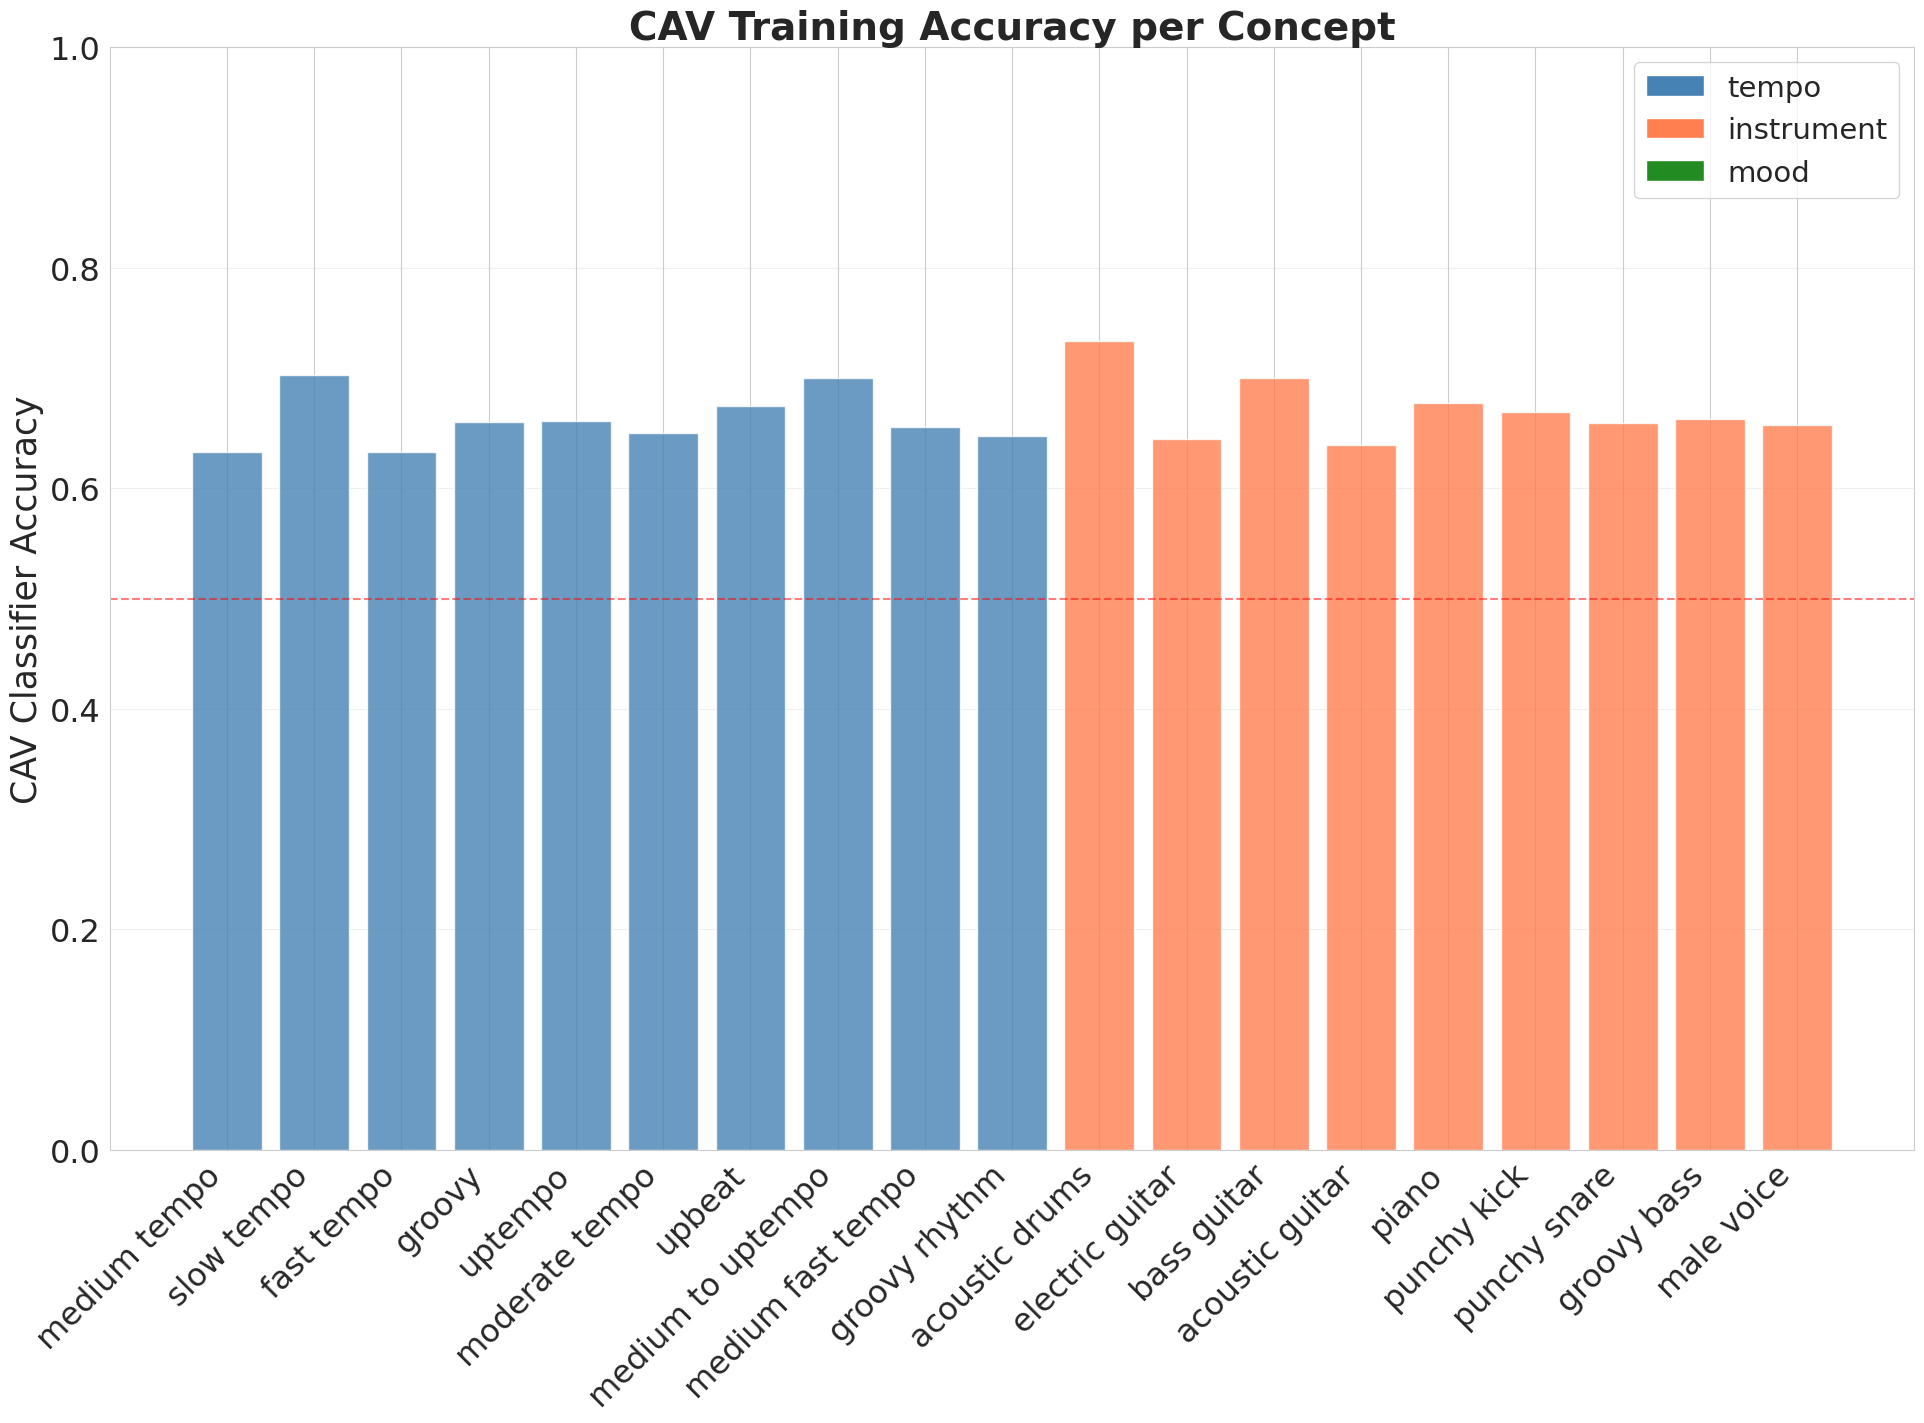

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

accuracies = []
labels = []
colors = []
color_map = {'tempo': 'steelblue', 'instrument': 'coral', 'mood': 'forestgreen'}

for category, concept_dict in results.items():
    for concept, data in concept_dict.items():
        accuracies.append(data['cav_accuracy'])
        labels.append(concept)
        colors.append(color_map.get(category, 'gray'))

bars = ax.bar(range(len(accuracies)), accuracies, color=colors, alpha=0.8)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('CAV Classifier Accuracy')
ax.set_title('CAV Training Accuracy per Concept', fontweight='bold')
ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random baseline')
ax.set_ylim([0, 1])
ax.legend()
ax.grid(axis='y', alpha=0.3)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=cat) for cat, c in color_map.items()]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()